# Data Prep Space

This notebook file is here to make it easier to modify data extract files to suit the requirements of the pipeline. Should mainly be used for converting formats and changing column names.

In [65]:
from dotenv import load_dotenv
import psycopg2
import os
import sys
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import re

char_regex = re.compile(r'[^a-z]')

In [66]:
load_dotenv()

#-----------------------------------------------------------------------------#
# DB connection

conn = psycopg2.connect(
    database="postgres", 
    user='postgres', 
    password=os.environ["POSTGRES_PASSWORD"], 
    host='127.0.0.1', 
    port= '5432'
)


In [67]:

def print_psycopg2_exception(err):
    # get details about the exception
    err_type, err_obj, traceback = sys.exc_info()

    # get the line number when exception occured
    line_num = traceback.tb_lineno

    # print the connect() error
    print("\npsycopg2 ERROR:", err, "on line number:", line_num)
    print("psycopg2 traceback:", traceback, "-- type:", err_type)

    # psycopg2 extensions.Diagnostics object attribute
    print("\nextensions.Diagnostics:", err.diag)

    # print the pgcode and pgerror exceptions
    print("pgerror:", err.pgerror)
    print("pgcode:", err.pgcode, "\n")

def transaction_wrapper(func):
    def wrapper(*args, **kwargs):
        with conn: 
            with conn.cursor() as cur:
                try:
                    cur.execute("savepoint my_save_point")
                    return func(cur, *args, **kwargs)
                except (psycopg2.DatabaseError) as error:
                    print_psycopg2_exception(error)
                    cur.execute("rollback to savepoint my_save_point")
                    raise
                except Exception as e:
                    cur.execute("rollback to savepoint my_save_point")
                    raise
    return wrapper

@transaction_wrapper
def execute_query_and_return(cur, some_query):
    cur.execute(some_query)
    return cur.fetchall()

In [68]:
dobs = [dob[0] for dob in execute_query_and_return("SELECT DOB FROM RAW_DATA;")]

In [69]:
given_names = (name[0] for name in execute_query_and_return("SELECT given_name FROM RAW_DATA;") if name[0] is not None)

In [70]:
family_names = (name[0] for name in execute_query_and_return("SELECT family_name FROM RAW_DATA;") if name[0] is not None)

In [71]:
full_names = ((name[0], name[1]) for name in execute_query_and_return("SELECT given_name, family_name FROM RAW_DATA;") if name[0] is not None and name[1] is not None)

In [72]:
full_names_and_dobs = [
    (person[0], person[1], person[2]) 
    for person in execute_query_and_return(
        "SELECT given_name, family_name, dob FROM RAW_DATA;"
    ) if person[0] is not None 
        and person[1] is not None 
        and person[2] is not None
]

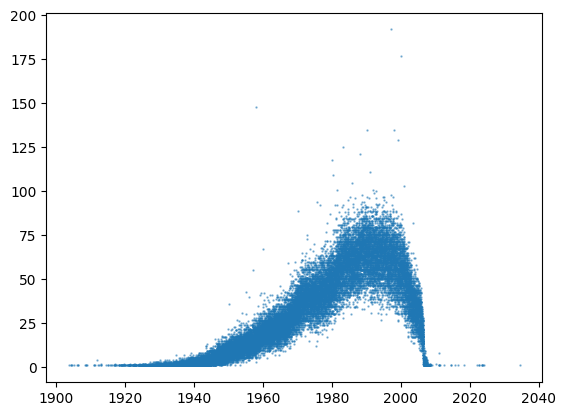

In [73]:
cutoffdate = datetime(year=1903, month=1, day=1).date()

dob_counts = defaultdict(lambda: 0)

for dob in dobs:
    if dob is not None and dob>cutoffdate:
        dob_counts[dob]+=1

dob_counts = sorted(list(dob_counts.items()), key=lambda item: item[0])

plt.scatter(
    [x[0] for x in dob_counts], 
    [y[1] for y in dob_counts], 
    alpha=0.5,
    s=0.5
    )

## Top 1000 Given Names By Count

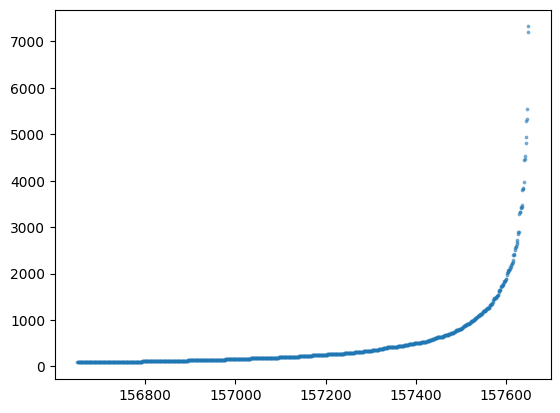

In [74]:
import re
display(Markdown("## Top 1000 Given Names By Count"))
given_counts = defaultdict(lambda: 0)

for name in given_names:
    if bool(re.sub(char_regex, '', name.lower())):
        given_counts[re.sub(char_regex, '', name.lower())]+=1

given_counts = [(index, item[1]) for index, item in enumerate(sorted(list(given_counts.items()), key=lambda item: item[1]))][-1000:]

plt.scatter(
    [x[0] for x in given_counts], 
    [y[1] for y in given_counts], 
    alpha=0.5,
    s=3
)





## Top 1000 Family Names By Count

Text(0, 0.5, 'percent')

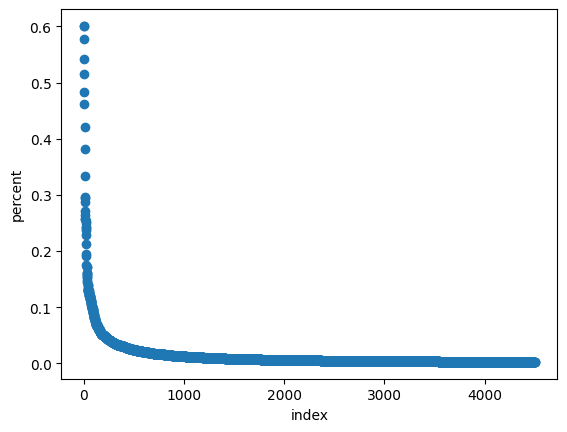

In [75]:
display(Markdown("## Top 1000 Family Names By Count"))
family_counts = defaultdict(lambda: 0)

for name in family_names:
    if bool(re.sub(char_regex, '', name.lower())):
        family_counts[re.sub(char_regex, '', name.lower())]+=1

total_families = sum(family_counts.values())

family_counts = [(index, item[1]) for index, item in enumerate(sorted(list(family_counts.items()), key=lambda item: item[1], reverse=True))][:4500]

plt.scatter(
    [x[0] for x in family_counts], 
    [100*y[1]/total_families for y in family_counts], 

)

plt.xlabel("index")
plt.ylabel("percent")

## Top 1000 Full Names Counted By Discrete Birthdays Between 1980 and 2000

Text(0, 0.5, 'percent')

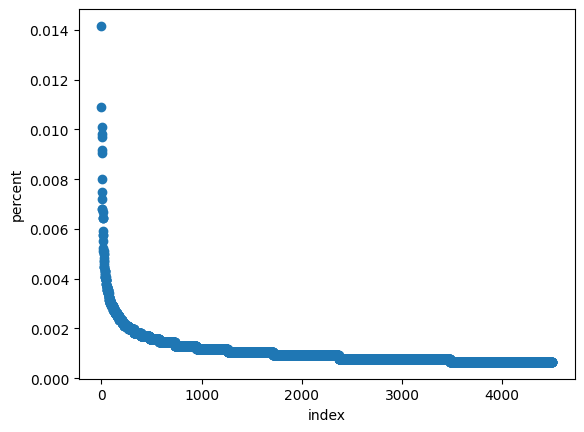

In [23]:
birthday_dict = defaultdict(lambda: set())

for person in full_names_and_dobs:
    birthday_dict[f"{re.sub(char_regex, '', person[0].lower())}{re.sub(char_regex, '', person[1].lower())}"].add(person[2])

person_count_dict = {name: len(birthday_set) for name, birthday_set in birthday_dict.items()}

total_people = sum(person_count_dict.values())

person_counts_list = [(index, value*100/total_people) for index, value in enumerate(sorted(list(person_count_dict.values()), reverse=True))][:4500]

display(Markdown("## Top 1000 Full Names Counted By Discrete Birthdays Between 1980 and 2000"))

plt.scatter(
    [x[0] for x in person_counts_list], 
    [y[1] for y in person_counts_list], 
#    alpha=0.5,
#    s=10
)

plt.xlabel("index")
plt.ylabel("percent")






([<matplotlib.axis.XTick at 0x7f5685a0d060>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

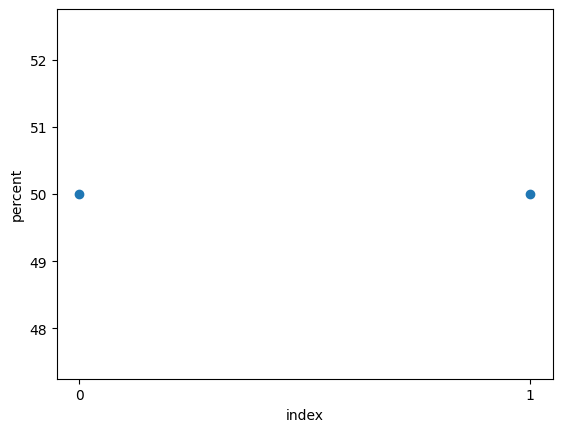

In [26]:

plt.scatter(
    [x for x in range(2)], 
    [50 for y in range(2)], 
#    alpha=0.5,
#    s=10
)

plt.xlabel("index")
plt.ylabel("percent")
plt.xticks([0, 1])




In [35]:
display(Markdown("## Naive Collision Probabilities"))
def collision_probability(num_peeps):
    chance_ok = 1
    for x in range(num_peeps):
        chance_ok = chance_ok * ((32850-x)/32850)
    return (1-chance_ok)*100

total = sum(person_count_dict.values())

top_ten = {name: count for name, count in person_count_dict.items() if count>=person_counts_list[-10][1]}

for name, count in top_ten.items():
    print(f"{name} appears ~{count} times overall -> {collision_probability(count)}% chance of collision")

## Naive Collision Probabilities

harpreetsingh appears ~77 times overall -> 8.528319120629025% chance of collision
gurpreetsingh appears ~74 times overall -> 7.898928934963479% chance of collision
amandeepkaur appears ~83 times overall -> 9.848528638786735% chance of collision
ramandeepkaur appears ~61 times overall -> 5.421687707609124% chance of collision
mandeepkaur appears ~57 times overall -> 4.744968856816234% chance of collision
jaspreetkaur appears ~55 times overall -> 4.422284989352776% chance of collision
harpreetkaur appears ~75 times overall -> 8.106401667347429% chance of collision
manpreetsingh appears ~69 times overall -> 6.89713383813928% chance of collision
sandeepkaur appears ~70 times overall -> 7.092692369803466% chance of collision
manpreetkaur appears ~108 times overall -> 16.14512750322773% chance of collision


(datetime.date(1997, 1, 1), 192)


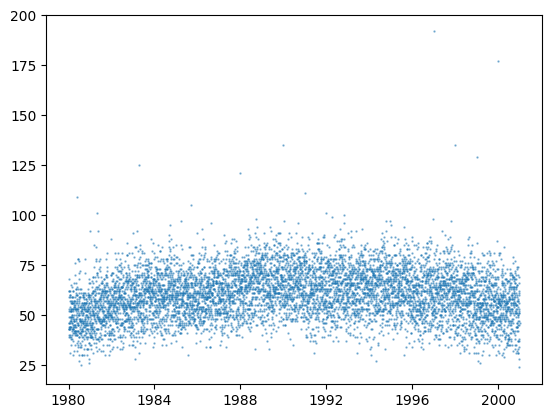

In [52]:
early_cutoffdate = datetime(year=1980, month=1, day=1).date()
late_cutoffdate = datetime(year=2000, month=12, day=31).date()

dob_counts = defaultdict(lambda: 0)

for dob in dobs:
    if dob is not None and early_cutoffdate<dob<late_cutoffdate:
        dob_counts[dob]+=1

dob_counts = sorted(list(dob_counts.items()), key=lambda item: item[0])

plt.scatter(
    [x[0] for x in dob_counts], 
    [y[1] for y in dob_counts], 
    alpha=0.5,
    s=0.5
    )

print(sorted(dob_counts, key=lambda item: item[1])[-1])

In [61]:
full_names_and_dobs = [
    (person[0], person[1], person[2]) 
    for person in execute_query_and_return(
        "SELECT given_name, family_name, dob FROM RAW_DATA;"
    ) if person[0] is not None 
        and person[1] is not None 
        and person[2] is not None
]

early_cutoffdate = datetime(year=1920, month=1, day=1).date()
late_cutoffdate = datetime(year=1920, month=12, day=31).date()

def collision_probability(num_peeps, num_days):
    chance_ok = 1
    for x in range(num_peeps):
        chance_ok = chance_ok * ((num_days-x)/num_days)
    return (1-chance_ok)

def calculate_collision_probability(person_data, early_date, late_date):
    chance_safe = 1

    char_regex = re.compile(r'[^a-z]')

    delta = late_date-early_date
    num_days = delta.days

    birthday_dict = defaultdict(lambda: set())
    print(f"Assembling person data with birthdays between {early_date} and {late_date}...")
    for person in tqdm(person_data):
        if early_date<person[2]<late_date:
            birthday_dict[f"{re.sub(char_regex, '', person[0].lower())}{re.sub(char_regex, '', person[1].lower())}"].add(person[2])

    person_count_dict = {name: len(birthday_set) for name, birthday_set in birthday_dict.items()}

    print(f"Calculating collision chance for {sum(person_count_dict.values())} people over {num_days} possible birthdays...")
    for count in tqdm(person_count_dict.values()):
        chance_safe *= (1-collision_probability(count, num_days))

    return 1-chance_safe

print(f"\nOVERALL PROBABILITY OF AT LEAST ONE COLLISION: {calculate_collision_probability(full_names_and_dobs, early_cutoffdate, late_cutoffdate):.2%}")




Assembling person data with birthdays between 1920-01-01 and 1920-12-31...


100%|██████████| 846358/846358 [00:00<00:00, 2282960.61it/s]


Calculating collision chance for 8 people over 365 possible birthdays...


100%|██████████| 8/8 [00:00<00:00, 47527.52it/s]


OVERALL PROBABILITY OF AT LEAST ONE COLLISION: 0.00%


In [69]:

def collision_probability(num_peeps, num_days):
    chance_ok = 1
    for x in range(num_peeps):
        chance_ok = chance_ok * ((num_days-x)/num_days)
    return (1-chance_ok)

def calculate_collision_probability(person_data, early_date, late_date):
    chance_safe = 1

    char_regex = re.compile(r'[^a-z]')

    delta = late_date-early_date
    num_days = delta.days

    birthday_dict = defaultdict(lambda: set())
    
    for person in person_data:
        if early_date<person[2]<late_date:
            birthday_dict[f"{re.sub(char_regex, '', person[0].lower())}{re.sub(char_regex, '', person[1].lower())}"].add(person[2])

    person_count_dict = {name: len(birthday_set) for name, birthday_set in birthday_dict.items()}

    
    for count in person_count_dict.values():
        chance_safe *= (1-collision_probability(count, num_days))

    return 1-chance_safe


## Minimum Risk Of Collision On Name And Birthday, By Birth Year

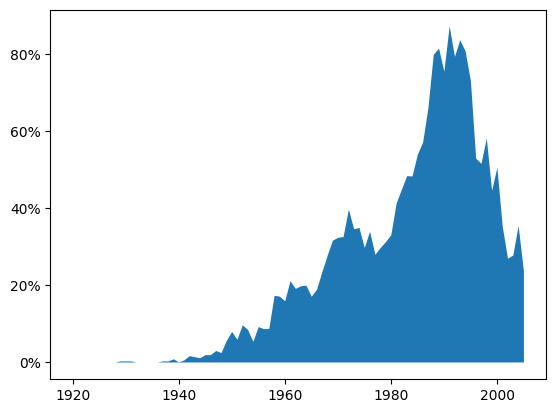

In [86]:
import matplotlib.ticker as mtick
yearly_risk = dict()

for eachyear in range(1920, 2006):
    yearly_risk[eachyear] = calculate_collision_probability(full_names_and_dobs, datetime(year=eachyear, month=1, day=1).date(), datetime(year=eachyear, month=12, day=31).date())

ax = plt.fill_between(
    x=yearly_risk.keys(),
    y1=yearly_risk.values()
).axes

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


display(Markdown("## Minimum Risk Of Collision On Name And Birthday, By Birth Year"))
plt.show()

In [97]:
calculate_collision_probability(full_names_and_dobs, datetime(year=2010, month=1, day=1).date(), datetime(year=2019, month=12, day=31).date())

0.0